In [1]:
import numpy as np
from scipy.stats import chi2
from scipy import special
import matplotlib.pyplot as plt
import matplotlib as mpl
import ROOT as rt
import time

%matplotlib inline
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.markersize'] = np.sqrt(20)
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['patch.facecolor'] = 'b'

mpl.rc('figure', titlesize=30)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=15)
mpl.rc('figure', figsize=(8, 6))

%load_ext Cython

Welcome to JupyROOT 6.12/06


# Esercizio  1
Lo scopo dell'esercizio è quello di implementare un generatore di numeri casuali e di utilizzarlo per generare dei numeri casuali distribuiti secondo la distribuzione di Breit-Wigner.

I numeri vengono inizialmente generati uniformemente tra 0 e 1. In seguito viene utilizzato il metodo della funzione inversa per generare un campione secondo la funzione desiderata.


## Generatore di numeri casuali col metodo MWC

Il metodo utilizzato è chiamato __Multiply With Carry__ (MWC). E' un metodo inventato da George Marsaglia. I vantaggi sono che l'aritmetica si basa su operazioni XOR facilmente eseguite dai processori e il periodo va da $2^{60}$ a $2^{2000000}$.

La formula è simile a quella di un generatore lineare di numeri congruenti, con la differenza che l'addendo varia ad ogni operazione.

Una sintesi dell'algoritmo può essere descritta dai seguenti passaggi:

* Si sceglie il modulo dell'operazione $b$. Tipicamente $b = 2^{32}$ in un'aritmetica del calcolatore a 64bit
* Si sceglie un valore di seed $x_0$
* Si sceglie un valore $a < b$
* Si sceglie un valore $c < a$. Tipicamente viene preso il valore associato ai primi 32 bit di x

* Iterativamente vengono svolti i seguenti passaggi
    1. $$
        t \leftarrow a*x + c
        $$
    2. $$x \leftarrow t mod b $$
    3. $$c \leftarrow \lceil t / b\rceil $$
    
Con una scelta adeguata dei parametri MWC supera dei test che un LCG fallisce. In particolare, il valore di $a$ viene scelto in modo tale da rendere la quantità $ab - 1$ e $(ab - 1) / 2$due numeri primi.
Il fatto di scegliere b in base 2 permette di eseguire operazioni aritmetiche immediate per i calcolatori (b in questo caso è la meta della dimensione di un registro a 64bit).
Si può dimostrare che utilizzando $b = 2^{32}$ il  periodo non è una potenza di 2. Nel caso in cui la scelta di $a$sia quella menzionata sopra il periodo è $(ab - 1) / 2$. Questo metodo viene generalmente utilizzato combinato con altri generatori di numeri casuali come ad esempio __KISS__

In [2]:
%%cython
# routine in C per generare una sequenza di numeri
# casuali utilizzando MWC. Il valore iniziale
# di x0 viene scelto prendendo l'istante
# di esecuzione dello script
import numpy as np
import time
cpdef generate_sequence(sequence):
    size = np.size(sequence)
    cdef unsigned long long x = int(time.time())
    # a è un valore suggerito da George Marsaglia
    cdef unsigned long long a = 0xffffda61
    cdef double value
    for i in range(size):
        # Quando moltiplico per a il resto finisce nei 
        # 32 bit superiori e il nuovo valore di x
        # finisce nei 32 bit inferiori. Ciò mi 
        # permette di utilizzare una singola 
        # variabile ed eseguire due operazioni
        # contemporaneamente
        x = (a * (x & 0xffffffff)) + (x >> 32)
        value = x
        sequence[i] = value
    return sequence

In [4]:
# Genera una sequenza di 1mln di double tra 0 e 1
# e moltiplica il risultato per 10 in modo da
# avere punti tra 0 e 10. Infine calcola
# e stampa alcune semplici statistiche
ULONG_MAX           = 18446744073709551615
sequence            = np.zeros(1000000, np.uint64)
sequence            = generate_sequence(sequence)  
normalized_sequence = sequence / ULONG_MAX
normalized_sequence *= 10
mean                = np.mean(sequence)
std                 = np.std(sequence)

print('Mean: {:.3e}'.format(mean))
print('Std: {:.3e}'.format(std))

Mean: 9.217e+18
Std: 5.324e+18


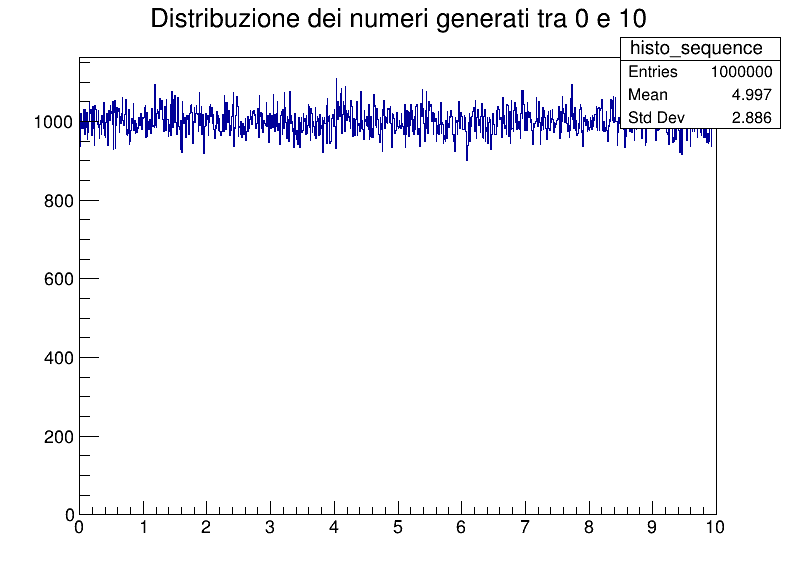

In [5]:
# Istogramma della distribuzione tra 0 e 10

histo = rt.TH1F("histo_sequence", 
                "Distribuzione dei numeri generati tra 0 e 10", 
                1000, 0., 10.)
for el in np.nditer(normalized_sequence):
    histo.Fill(el)

c = rt.TCanvas("myCanvasName","The Canvas Title",800,600)
histo.Draw()
histo.SetMinimum(0)
c.Draw()


## Test statistici di casualità
### Overlapping sums test

Un generatore di numeri casuali è tipicamente sottoposto ad una serie di test per evidenziare eventuali non unfiormità nel generatore stesso. Un esempio di test è quello dell'__overlapping sums test__: consiste nel generare una sequenza di numeri tra 0 e 1. Vengono sommati fra di loro delle sequenze consecutive di numeri della sequenza. Per il teorema del limite centrale la distribuzione attesa è una gaussiana.
Il test si può riassumere nei seguenti passaggi:
1. Genero 1000000 numeri casuali tra 0 e 1
2. Divido l'intervallo in tanti campioni consecutivi di 100 elementi. Se ad esempio la sequenza ha generato in numeri
`[0.1, 0.3, 0.2, 0.12, ...]` i primi campioni saranno `[0.1, 0.3, 0.2, ...], [0.3, 0.2, 0.12, ...], [0.2, 0.12, ...]`, tutti della stessa lunghezza.
3. Sommo i campioni fra di loro e ottengo una lista di somme grande quanto il numero di campioni
4. Osservo la distribuzione delle somme

In [22]:
# trucchetto per generare un array 2d in cui nelle righe ci sono
# sequenze di 100 elementi consecutivi dei numeri generati. 
# Ogni riga è shiftata di un elemento rispetto a quella 
# successiva. Calcola poi la somma di tutte le righe
indexer = np.arange(100)[None, :] + np.arange(np.size(sequence) - 99)[:, None]
windows = normalized_sequence[indexer]
sums    = np.sum(windows, axis=1)

 FCN=1117.64 FROM MIGRAD    STATUS=FAILED         68 CALLS          69 TOTAL
                     EDM=3.72898e+26    STRATEGY= 1      ERR MATRIX APPROXIMATE
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.56384e+03   4.35612e+00   0.00000e+00  -1.80137e-04
   2  Mean         4.99665e+02   5.40248e+08   0.00000e+00  -7.14877e+04
   3  Sigma        2.88397e+01   2.02723e-02   0.00000e+00  -2.82126e+00


Warning in <TROOT::Append>: Replacing existing TH1: histo_sums (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_histo_sums


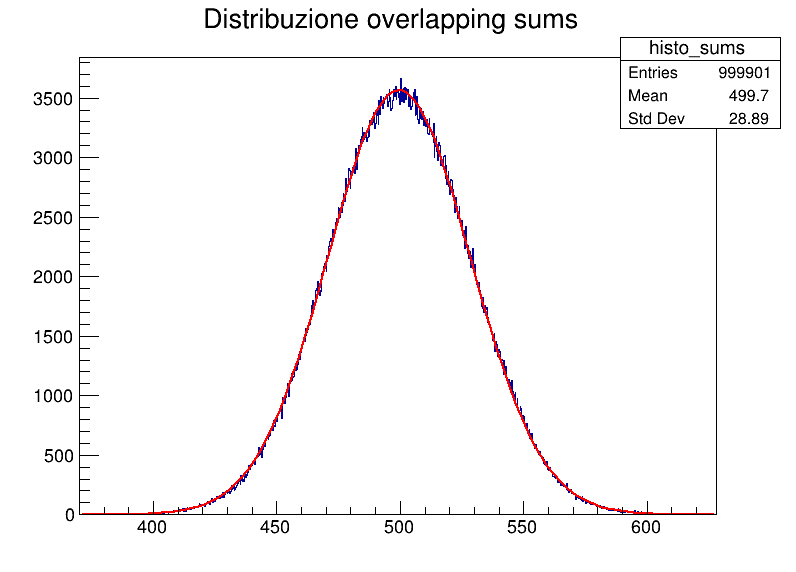

In [23]:
# Istogramma della distribuzione delle somme
histo_sums = rt.TH1F("histo_sums", "Distribuzione overlapping sums", 1000, np.min(sums), np.max(sums))
for el in np.nditer(sums):
    histo_sums.Fill(el)

histo_sums.Fit("gaus")
c_sums = rt.TCanvas("canvas_histo_sums","Overlapping sums",800,600)
histo_sums.Draw()
histo_sums.SetMinimum(0)
c_sums.Draw()

## Spectral test

Un test visivo è quello spettrale. Vengono mostrati sui tre assi cartesiani $(x, y, z)$ la distribuzione $(u, u+1, u+2)$. Per alcuni generatori (come ad esempio il generatore lineare di numeri congruenti) si nota l'esistenza di un pattern. Se invece il generatore è sufficientemente robusto non è possibile trovare una direzione di osservazione in cui tali pattern sono evidenti

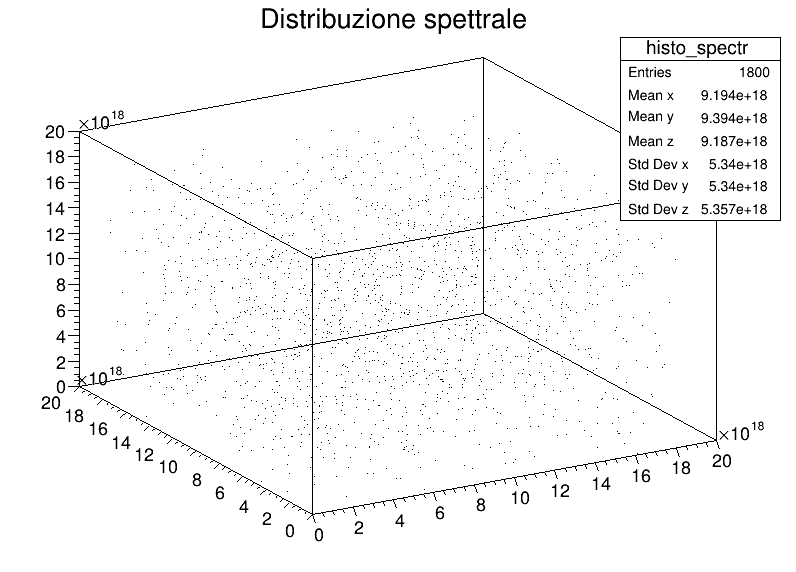

In [24]:
low, up = sequence[1000], sequence[10000]
histo_spectr = rt.TH3F("histo_spectr", "Distribuzione spettrale", 
                       100, low, up, 
                       100, low, up,
                       100, low, up)
x = sequence[1000:10000:5]
y = np.roll(sequence, 1)[1000:10000:5]
z = np.roll(sequence, 2)[1000:10000:5]

for xel, yel, zel in np.nditer([x, y, z]):
    histo_spectr.Fill(xel, yel, zel)
    
c_spectr = rt.TCanvas("c_spectr", "Distribuzione spettrale", 800, 600)
histo_spectr.Draw()
c_spectr.Draw()

Viene mostrata in seguito un'altra angolazione e una rappresentazione spettrale in due dimensioni

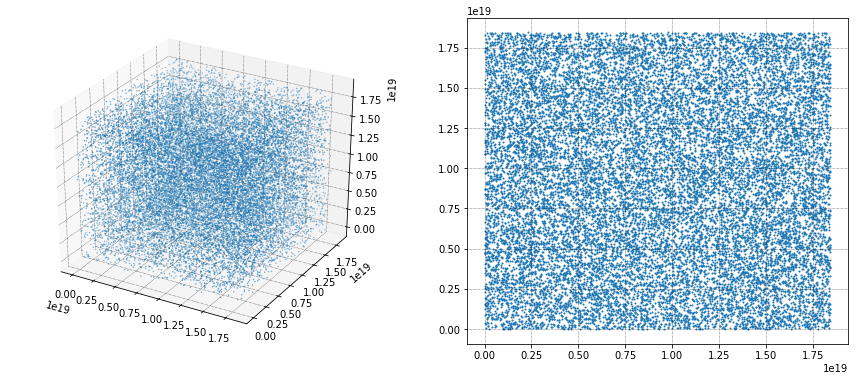

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(sequence[1000:100000:5], np.roll(sequence, 1)[1000:100000:5], 
           np.roll(sequence, 2)[1000:100000:5], s=0.2)

ax2 = fig.add_subplot(122)
ax2.scatter(sequence[1000:100000:5], np.roll(sequence, 3)[1000:100000:5], s=1)

## Monobit test

Se analizzo l'intera sequenza in termini di bit, mi aspetto che vi sia un'equa distribuzione di 0 e 1. La procedura di test prende spunto dalla pubblicazione http://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-22r1a.pdf
e consiste nel:
1. Convertire gli 0 in somme di -1.
2. Calcolare la somma di tutti i bit. Ad esempio, se la sequenza è 1001101111 allora nbits = 10
   $$
       S_n = 1 + -1 + -1 + 1 + 1 + -1 + 1 + 1 + 1 + 1 = 4
   $$
3. Calcolare la statistica
   $$
       s_{obs} = \frac{|S_n|}{\sqrt{n}}
   $$
4. Calcolare il p-value come
    $$
        p = 1 - erf\left(\frac{s_{obs}}{\sqrt{2}}\right)
    $$
5. Se p-value < 1% allora la sequenza non è random. Altrimenti l'algoritmo è robusto


In [ ]:
# La riga sotto mi serve solo per controllare di stare scrivendo il
# codice in cython in maniera corretta
# Preso spunto da http://gurmeet.net/puzzles/fast-bit-counting-routines/

# count2 = np.sum([ bin(el).count('1') for el in slicearray ])

In [26]:
%%cython
# Le funzioni sono implementate
# utilizzando i suggerimenti dell'articolo:
# http://gurmeet.net/puzzles/fast-bit-counting-routines/
cpdef get_count(sequence, size):
    cdef int countones = 0
    cdef int countzeroes = 0
    for i in range(size):
        count1, count0 = iterated_bitcount(sequence[i])
        countones += count1
        countzeroes += count0
    return countones, countzeroes

cdef iterated_bitcount(unsigned long long n):
    cdef int countones = 0
    cdef int countzeroes = 0
    cdef short int result
    cdef unsigned long long mask = 0x1
    for i in range(64):
        result = n & mask
        if result:
            countones += 1
        else:
            countzeroes += 1
        n >>= 1
    return countones, countzeroes

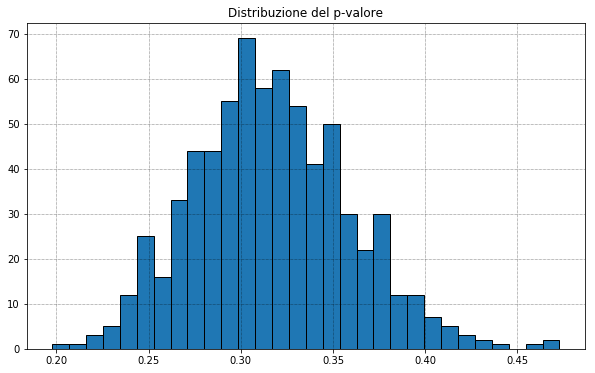

In [29]:
pvalues = np.array([])
plt.figure(figsize=(10, 6))
for i in range(700):
    count1, count0 = get_count(sequence[700*i:700*i +100], 
                               np.size(sequence[700*i:700*i +100]))
    Sn = count1 - count0
    Sobs = np.abs(Sn / np.sqrt(np.size(sequence)))
    p = special.erfc(Sobs / np.sqrt(2))
    pvalues = np.append(pvalues, p)

plt.hist(pvalues, bins=30);
plt.title('Distribuzione del p-valore');

## Generazione numeri casuali secondo distribuzione di Breit-Wigner

La pdf di Breit-Wigner o di Cauchy è definita come:
$$
f(x; x_0,\gamma) = \frac{1}{\pi\gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]} = { 1 \over \pi \gamma } \left[ { \gamma^2 \over (x - x_0)^2 + \gamma^2  } \right],
$$
La sua cdf invece è:
$$
F(x; x_0,\gamma)=\frac{1}{\pi} \arctan\left(\frac{x-x_0}{\gamma}\right)+\frac{1}{2}
$$

Per generare numeri casuali secondo Breit-Wigner viene utilizzato il metodo della trasformata inversa:
* Voglio generare numeri distribuiti secondo una r.v x che ha come pdf la funzione di Cauchy f(x)
* Conosco la cdf F(x) e la so invertire
* Definisco u come una r.v. uniforme in (0,1) e calcolo $x = F^{-1}(u)$. x sarà allora distribuita come f(x)

Nella forma standard della distribuzione di Cauchy si ha che:

$$
F(x) = \frac{1}{2} + \frac{\arctan(x)}{\pi} \\
F^{-1}(u) = \tan(\pi(u - 1/2))
$$

In [30]:
def cdf(x):
    return 1/np.pi * np.arctan(x) + 1 / 2

def inversecdf(u):
    return np.tan(np.pi * (u - 0.5))

vcdf = np.vectorize(cdf)
vinversecdf = np.vectorize(inversecdf)

In [31]:
uniform_sequence = normalized_sequence / 10.

In [37]:
cauchy_sequence = vinversecdf(uniform_sequence)
# Vengono tagliati i valori molto distanti dalla coda per 
# avere una visualizzazione migliore della pdf caratteristica
cauchy_sequence = cauchy_sequence[(cauchy_sequence < 25) & (cauchy_sequence > -25)]

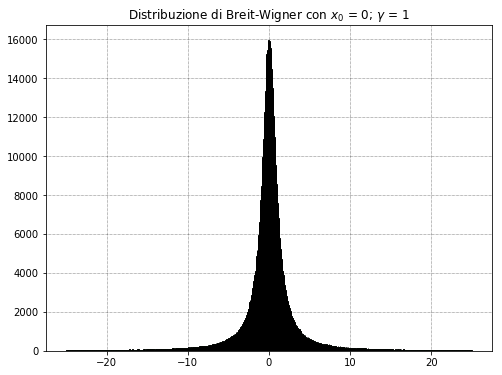

In [40]:
plt.title('Distribuzione di Breit-Wigner con $x_0$ = 0; $\\gamma$ = 1')
plt.hist(cauchy_sequence, bins=1000, color='C2');